In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV, GroupKFold, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report
from sklearn.utils import shuffle
import warnings

warnings.filterwarnings("ignore")

# define model
logistic_model = LogisticRegression(multi_class='multinomial',solver='lbfgs')
tree_model = DecisionTreeClassifier(criterion='entropy',random_state=42)

# define pipeline
pipe_logistic = Pipeline([('model', logistic_model)])
pipe_tree = Pipeline([('model', tree_model)])

# define hyperparameters to tune （because our dataset still have noise after denoise)
param_grid_logistic = {'model__C': [0.001, 0.01, 0.1, 1, 10, 100]}

param_grid_tree = {'model__max_depth': [3, 5, 7, 10, 15, 20, None],
                    'model__min_samples_split': [2, 5, 10, 20, 30, 40, 50],
                    'model__min_samples_leaf': [1, 2, 5, 10, 15, 20]}

# choose to drop which columns
drop_list = ['filename', 'label', 'band_energy_ratio_800', 'band_energy_ratio_1600', 'duration', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5' ]


In [2]:
def group_straified(df):

    # get sample id and label
    filenames = df['filename'].unique()
    labels = df['label'].unique()

    # create a list to store the indices of each group
    group_indices = [[] for i in range(5)]
    sample_indices = {filename: df[df['filename'] == filename].index for filename in filenames}
    assigned_samples = set()

    # compute the number of samples that each label should be assigned to each group
    label_counts = {}
    for label in labels:
        # get the the number of samples of each label
        count = len(df[df['label'] == label])
        # comput the lower limit of the number of samples that each label should be assigned to each group
        label_counts[label] = count // 5 if count > 0 else 0

    # ramdomly assign samples to 5 group
    rng = np.random.default_rng(seed=1234)
    for i in range(5):
        for label in labels:
            # get the filenames of the samples of each label
            filenames_label = df[df['label'] == label]['filename'].unique()
            # ramdomly shuffle the filenames
            rng.shuffle(filenames_label)
            # get the number of samples that each label should be assigned to each group
            count = label_counts[label]
            label_count = 0
            indices = []
            # ramdomly assign samples to each group
            for filename in filenames_label:
                # if the sample has been assigned to a group, skip it
                if filename in assigned_samples:
                    continue
                # get the indices of the sample
                indices.extend(sample_indices[filename])
                label_count += len(sample_indices[filename])
                # add the sample to the assigned_samples set
                assigned_samples.add(filename)
                # if the number of samples of each label assigned to each group is greater than the lower limit, break
                if label_count >= count:
                    break
            
            # add the indices of the samples to the group_indices list
            group_indices[i].extend(indices)
    
    for filename in filenames:
        if filename not in assigned_samples:
            i = np.random.randint(0, 5)
            # get the indices of the sample
            indices = sample_indices[filename]
            # add the sample to the assigned_samples set
            assigned_samples.add(filename)
            # add the indices of the samples to the group_indices list
            group_indices[i].extend(indices)
                
               
    return group_indices

In [3]:
# create a GroupKFold object
df = pd.read_csv('animal_features.csv')
remove_list = ['pig','crow','frog','hen', 'rooster']
df.drop(index=df[df['label'].isin(remove_list)].index, inplace=True)
df = df.reset_index(drop=True)

# define two lists to store the training set and test set
train_data, test_data = [], []
train_index,test_index = [], []

# for _, group in groups:
#     # 获取当前分组的所有数据点
#     X_group = group.drop('label', axis=1)  # 去掉输出y列，得到输入特征X
#     y_group = group['label']  # 获取输出y列

#     # 将当前分组按照指定比例划分为训练集和测试集
#     X_train_group, X_test_group, y_train_group, y_test_group = train_test_split(X_group, y_group, test_size=0.2, random_state=42)

#     # 将划分后的训练集和测试集添加到对应的列表中
#     train_data.append(pd.concat([X_train_group, y_train_group], axis=1))
#     test_data.append(pd.concat([X_test_group, y_test_group], axis=1))

# get 5 fold from df with their indices
fold = group_straified(df)

for i in range(4):
    train_index.extend(fold[i])

test_index.extend(fold[4])


# combine the 4 folds to form the training set and test set
train_set = df.iloc[train_index].reset_index(drop=True)
test_set =  df.iloc[test_index].reset_index(drop=True)

train_set.head()
test_set.head()

,filename,duration,label,AUC,max_freq,spectral_centroid,band_energy_ratio_800,band_energy_ratio_1600,one_ratio_band_energy_freq,power_bandwidth,...,spectral_skewness,spectral_spread,fundamental_frequency,interquartile_range,turning_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5
0,3-126358-A-3.wav,21104,cow,0.042308,211.054776,1746.955524,0.363980,7.102363,1018,1467.980004,...,2.683800,1639.945718,206.895081,0.059020,0.186884,-81.165430,145.962190,-57.541542,-30.962715,-6.470989
1,3-126358-A-3.wav,32087,cow,0.037478,1375.075576,2067.256117,0.057099,6.268272,1338,1213.584941,...,2.478168,1828.867713,588.980489,0.034458,0.182286,-24.907919,111.429400,-74.461410,-31.644344,5.993313
2,1-69641-A-3.wav,24033,cow,0.059880,486.268880,1983.604856,1.169445,4.529884,694,2068.936462,...,2.182445,2040.935270,317.490637,0.074667,0.170640,-64.982550,167.448490,-66.994530,0.816530,3.244080
3,1-69641-A-3.wav,10826,cow,0.026347,291.257159,3097.450931,0.427496,1.154657,1569,3560.262331,...,1.089790,2524.197607,179.268293,0.072047,0.320063,67.978570,24.345806,-52.066080,4.615654,-9.126470
4,4-181955-B-3.wav,17230,cow,0.012086,211.157864,1422.916712,1.671947,28.699372,599,1159.448636,...,2.690315,1449.768213,208.622591,0.023245,0.173360,-130.294130,151.302280,-49.113422,-15.389895,-29.258942


In [4]:
# load the training set
#df = pd.read_csv('your_data.csv')
df = train_set.reset_index(drop=True)
df2_train = df[['filename', 'label']].drop_duplicates().reset_index(drop=True)

# define x and y
groups = df['filename']
X_train = df.drop(drop_list, axis=1)
y_train = df['label']

# cross validation
gskf = group_straified(df)
cv = [(np.array(np.concatenate(gskf[:i]+gskf[i+1:])), np.array(gskf[i])) for i in range(4)]

# GrodSearchCV
grid_logistic = GridSearchCV(pipe_logistic, param_grid_logistic, cv=cv, n_jobs=-1, scoring=f1_score)
grid_tree = GridSearchCV(pipe_tree, param_grid_tree, cv=cv, n_jobs=-1, scoring=f1_score)
grid_logistic.fit(X_train, y_train)
grid_tree.fit(X_train, y_train)

# output the best model
best_logistic = grid_logistic.best_estimator_
best_tree = grid_tree.best_estimator_
print('Best Logistic Regression：', best_logistic)
print('Best Decision Tree Classifier：', best_tree)

最佳的逻辑回归模型： Pipeline(steps=[('model',
                 LogisticRegression(C=0.001, multi_class='multinomial'))])
最佳的决策树模型： Pipeline(steps=[('model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=3,
                                        random_state=42))])


In [5]:
#get the report of logistic regression
#get the model from pipeline
model = best_logistic.named_steps['model']

# create a dataframe to store the coefficients
coef_df = pd.DataFrame(model.coef_, columns=X_train.columns, index=model.classes_)
intercept_df = pd.DataFrame(model.intercept_, columns=['Intercept'], index=model.classes_)

coef_df.columns.name = 'Class'

# concatenate the intercept and coefficients
result_df = pd.concat([intercept_df, coef_df], axis=1)

result_df.T

,cat,cow,dog
Intercept,-0.005537,0.003339,0.002198
AUC,-0.000126,0.000653,-0.000527
max_freq,0.000617,-0.002395,0.001778
spectral_centroid,0.002801,-0.002087,-0.000715
one_ratio_band_energy_freq,0.001810,0.000524,-0.002334
power_bandwidth,-0.000606,0.000223,0.000383
kurtosis,0.002864,0.002485,-0.005349
skewness,-0.000177,0.000607,-0.000430
zcr,0.000011,0.000047,-0.000059
spectral_entropy,-0.002891,0.001589,0.001301


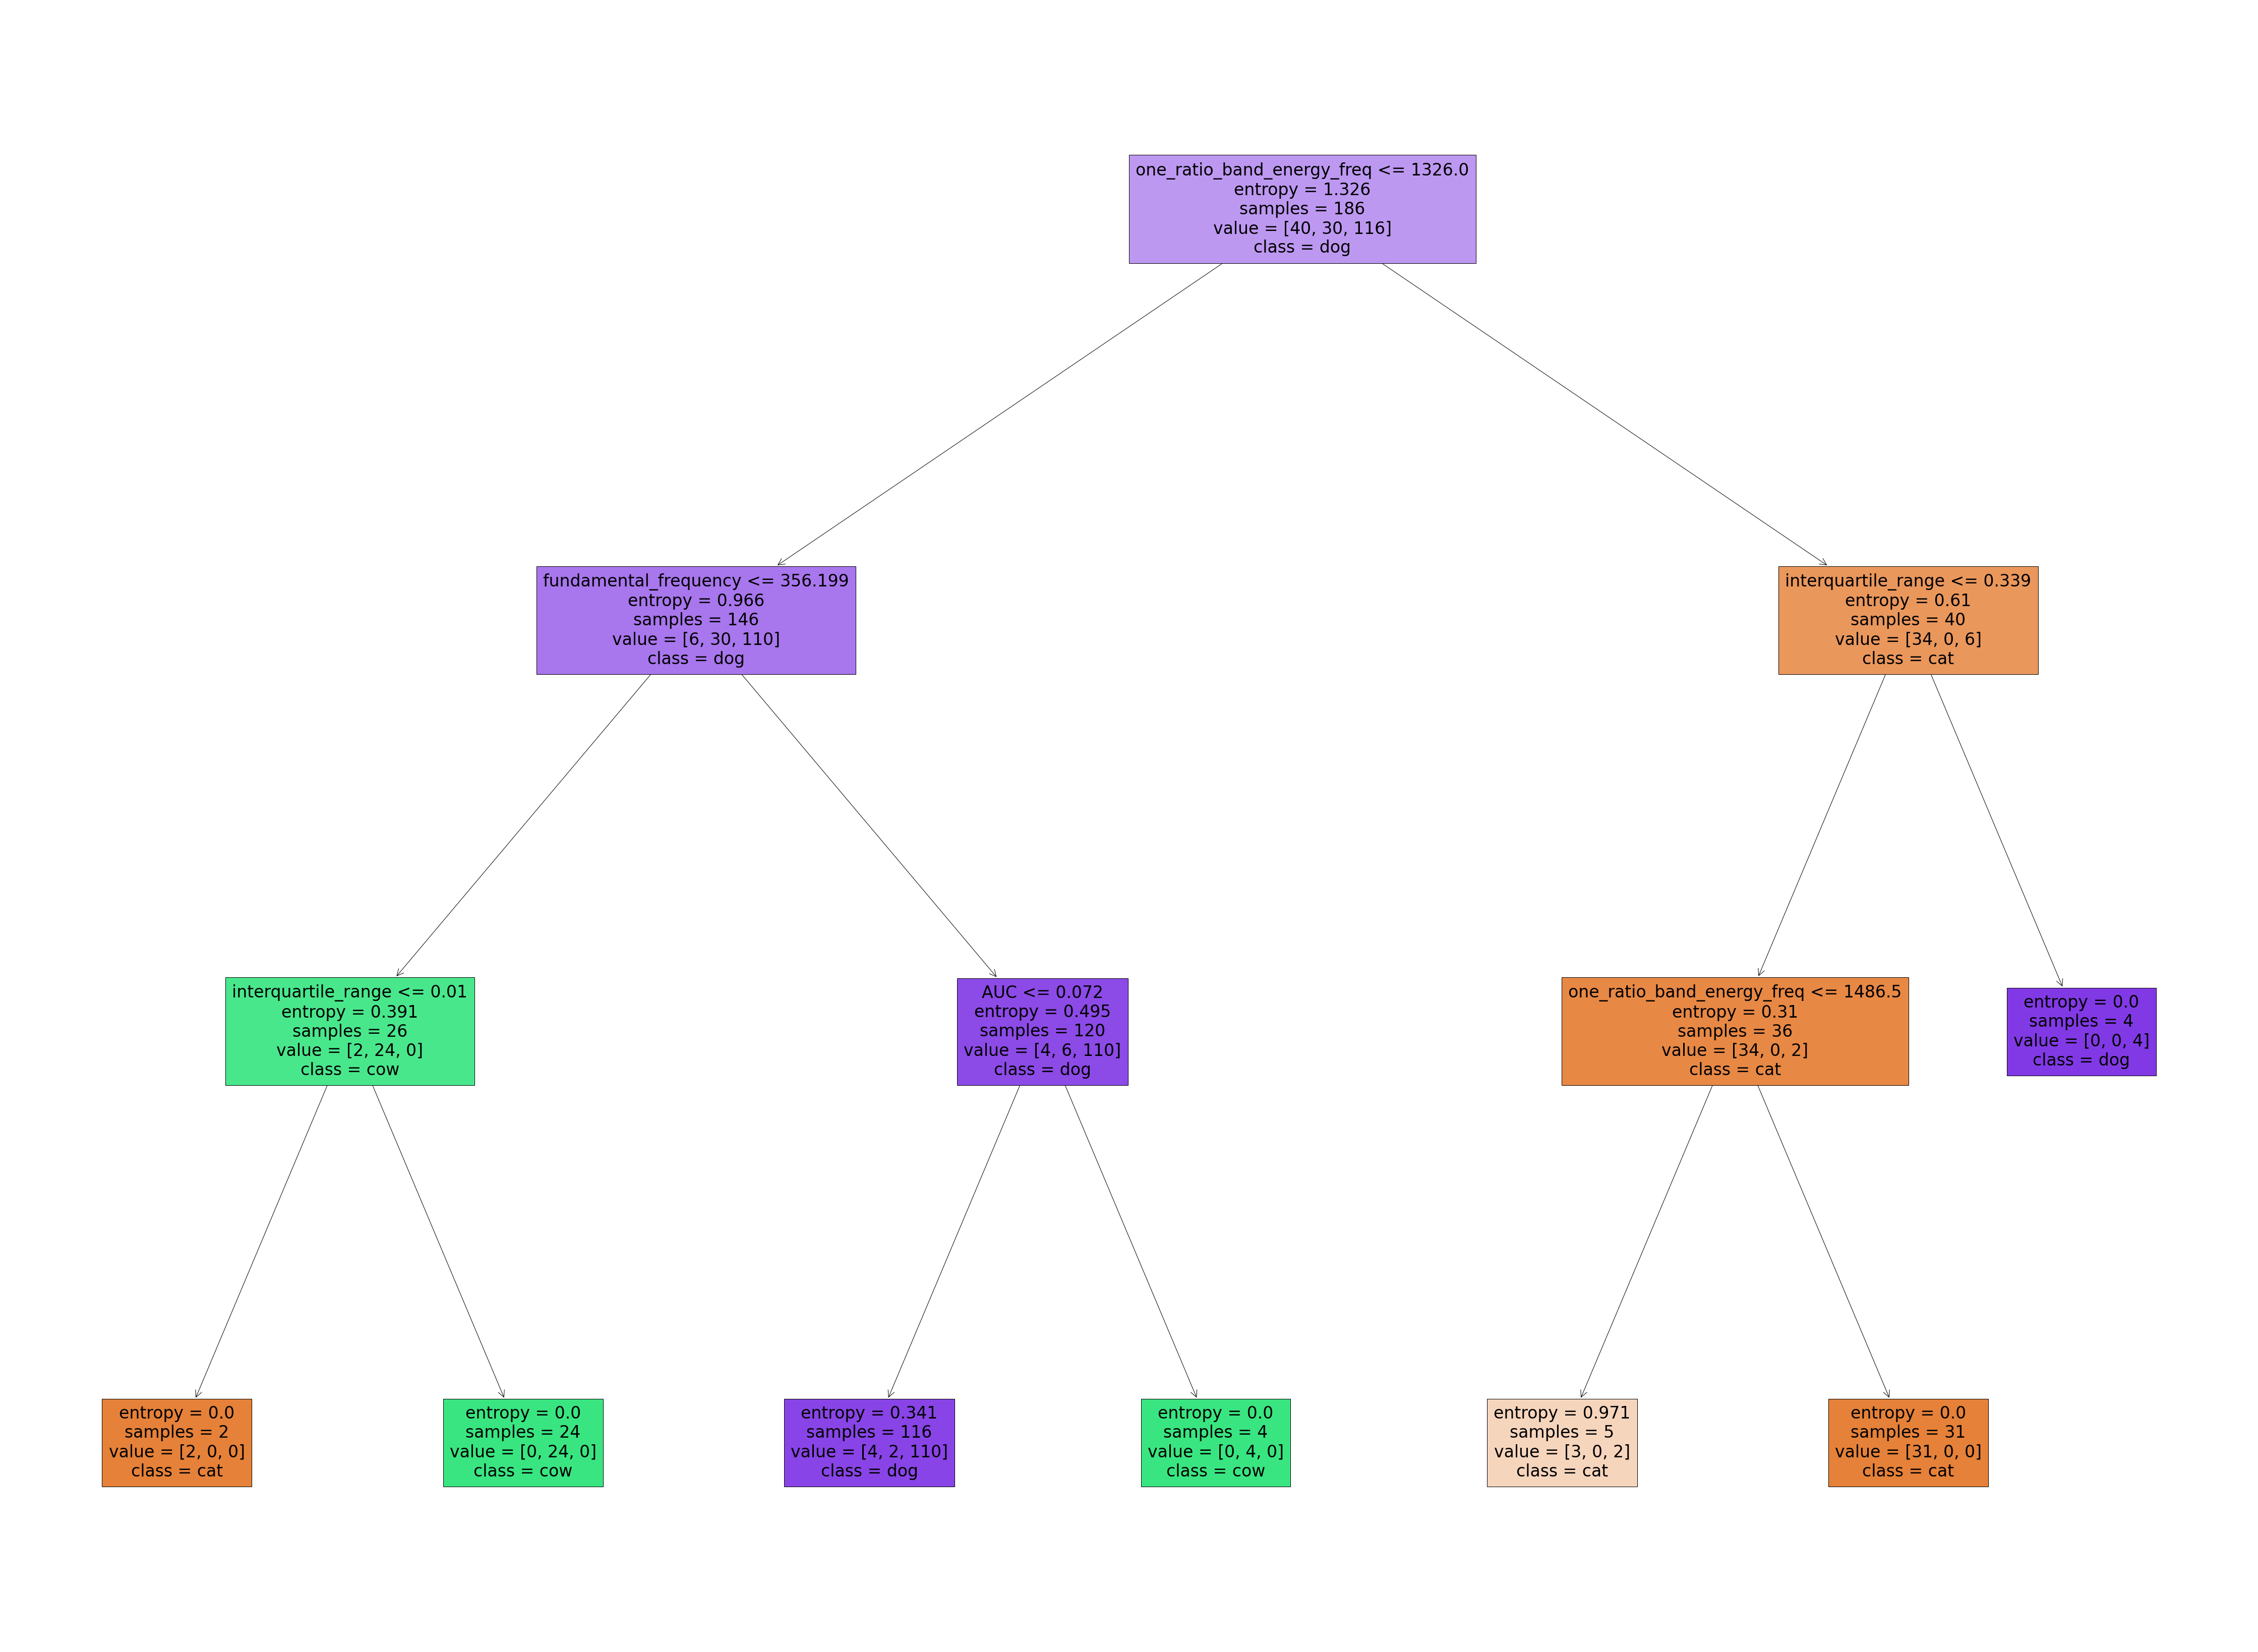

In [6]:
#get the report of logistic regression
#get the model from pipeline
model = best_tree.named_steps['model']

fig, ax = plt.subplots(figsize=(80, 60))
plot_tree(model, filled=True, feature_names=X_train.columns, class_names=model.classes_, ax=ax)
plt.show()


In [7]:
#predict and produce the confusion matrix
df = test_set.reset_index(drop=True)
df2_test = df[['filename', 'label']].drop_duplicates().reset_index(drop=True)

groups = df['filename']
X_test = df.drop(drop_list, axis=1)
y_test = df['label']


y_pred_train_logistic = best_logistic.predict(X_train)
y_pred_test_logistic = best_logistic.predict(X_test)
df['sub_predict_log'] = y_pred_test_logistic
y_pred_train_tree = best_tree.predict(X_train)
y_pred_test_tree = best_tree.predict(X_test)
df['sub_predict_tree'] = y_pred_test_logistic

f1_train_logistic = f1_score(y_train, y_pred_train_logistic, average='macro')
f1_test_logistic = f1_score(y_test, y_pred_test_logistic, average='macro')
f1_train_tree= f1_score(y_train, y_pred_train_tree, average='macro')
f1_test_tree = f1_score(y_test, y_pred_test_tree, average='macro')


# compute the confusion matrix
cm_train_logistic = confusion_matrix(y_train, y_pred_train_logistic)
cm_test_logistic = confusion_matrix(y_test, y_pred_test_logistic)
cm_train_tree = confusion_matrix(y_train, y_pred_train_tree)
cm_test_tree = confusion_matrix(y_test, y_pred_test_tree)


Text(0.5, 1.0, 'Classification Tree\n Test F1 score: 0.813')

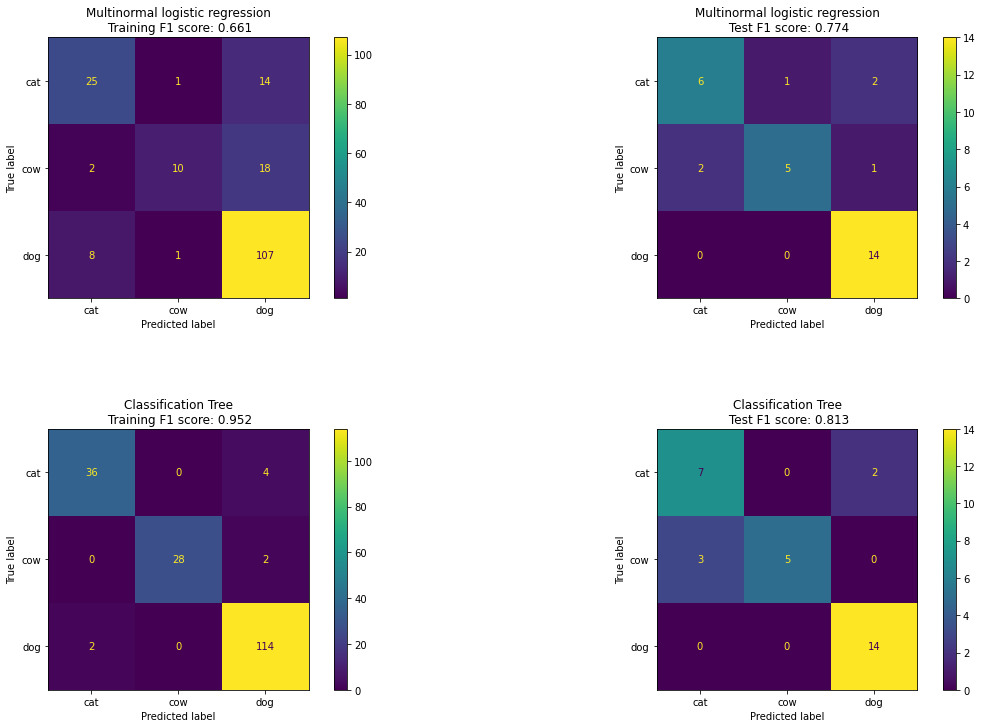

In [8]:
# display confusion matrix for sub-audio
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(20, 12))
plt.subplots_adjust(hspace=0.5)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train_logistic, display_labels=best_logistic.classes_)
disp.plot(ax=axes[0,0])
axes[0,0].set_title(f'Multinormal logistic regression\n Training F1 score: {f1_train_logistic:.3f}')

disp = ConfusionMatrixDisplay(confusion_matrix=cm_test_logistic, display_labels=best_logistic.classes_)
disp.plot(ax=axes[0,1])
axes[0,1].set_title(f'Multinormal logistic regression\n Test F1 score: {f1_test_logistic:.3f}')

disp = ConfusionMatrixDisplay(confusion_matrix=cm_train_tree, display_labels=best_tree.classes_)
disp.plot(ax=axes[1,0])
axes[1,0].set_title(f'Classification Tree\n Training F1 score: {f1_train_tree:.3f}')

disp = ConfusionMatrixDisplay(confusion_matrix=cm_test_tree, display_labels=best_tree.classes_)
disp.plot(ax=axes[1,1])
axes[1,1].set_title(f'Classification Tree\n Test F1 score: {f1_test_tree:.3f}')

In [9]:
# 按照 filename 列对数据进行分组，并计算每个分组的AUC总和
auc_sum_by_file = df.groupby('filename')['AUC'].sum()

# 计算每行的权重，即该行的AUC值除以其所属的文件的AUC总和
df['weighting'] = df.apply(lambda row: row['AUC'] / auc_sum_by_file[row['filename']], axis=1)
df = df.loc[:,['filename', 'label', 'sub_predict_log', 'sub_predict_tree', 'weighting']]

# 自定义函数，返回每个组中最高概率分类
def get_top_bylog(group):
    return group.groupby('sub_predict_log')['weighting'].sum().idxmax()

def get_top_bytree(group):
    return group.groupby('sub_predict_tree')['weighting'].sum().idxmax()

# 按照 filename 列进行分组，并应用 get_top_category 函数
predict_log = df.groupby('filename').apply(get_top_bylog).reset_index()
predict_log = predict_log.rename(columns={0: 'predict_log'})
predict_tree = df.groupby('filename').apply(get_top_bytree).reset_index()
predict_tree = predict_tree.rename(columns={0: 'predict_tree'})

df_last = df[['filename','label']].drop_duplicates().reset_index(drop=True)

df = pd.merge(df_last, pd.merge(predict_log, predict_tree, on='filename'), on='filename')



In [10]:
#calculate f1 and confusion matrix
y_pred_test_logistic_whole = best_logistic.predict(X_test)
y_pred_test_tree_whole = best_tree.predict(X_test)



f1_test_logistic_whole = f1_score(df['label'], df['predict_log'], average='macro')
f1_test_tree_whole = f1_score(df['label'], df['predict_tree'], average='macro')


# compute the confusion matrix
cm_test_logistic_whole = confusion_matrix(df['label'], df['predict_log'])
cm_test_tree_whole = confusion_matrix(df['label'], df['predict_tree'])

Text(0.5, 1.0, 'Classification Tree\n Test F1 score: 0.874')

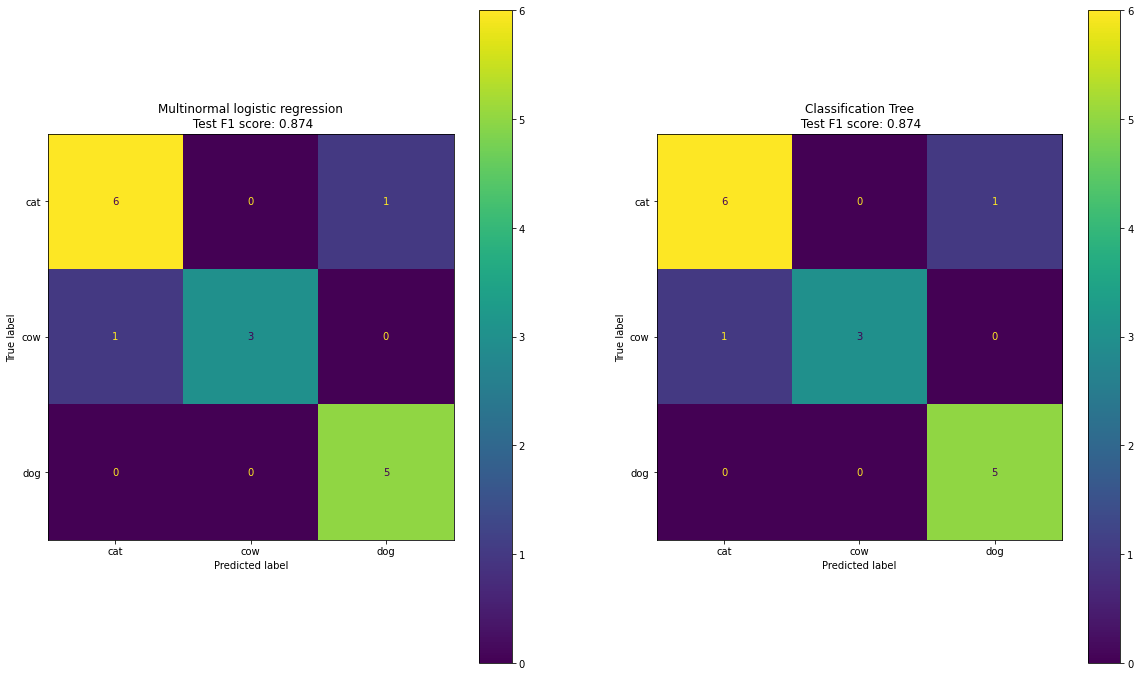

In [11]:
#display confusion matrix for the whole audio
fig, axes = plt.subplots(1, 2, figsize=(20, 12))
plt.subplots_adjust(hspace=0.5)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test_logistic_whole, display_labels=best_logistic.classes_)
disp.plot(ax=axes[0])
axes[0].set_title(f'Multinormal logistic regression\n Test F1 score: {f1_test_logistic_whole:.3f}')

disp = ConfusionMatrixDisplay(confusion_matrix=cm_test_tree_whole, display_labels=best_logistic.classes_)
disp.plot(ax=axes[1])
axes[1].set_title(f'Classification Tree\n Test F1 score: {f1_test_tree_whole:.3f}')
